### Notebook by [Volkan Sonmez](http://www.pythonicfool.com/)  
### Laughter (Audio) Categorization and Analysis with Convolutional Neural Networks. 
##### [Pythonicfool GitHub Repository](https://github.com/volkansonmez/Exploratory_Data_Analysis_and_ML_Projects)


## Table of contents

1. [Introduction](#Introduction)

2. [EDA and Building ML Model](#EDA_and_Building_ML_Model)

3. [Conclusion](#Conclusion)

## Introduction

[[ go back to the top ]](#Table-of-contents)

This notebook detects if the laughter recordings in the dataset are sincere or fake. I am the culprit who produced and recorded these creepy audio files. 

The 'laugh' folder has 12 laughter audio files for training. 
The 'laugh_test' folder has 10 audio files for testing and validation.

Laughers are analyzed with Matplot and Librosa Libraries. A 3 layer convolutional neural network with a 2 dimensional output is built and trained to detect the sincerity of these samples.

> The dataset can be obtained at: https://github.com/volkansonmez/Exploratory_Data_Analysis_and_ML_Projects/tree/master/Audio%20Dataset 

## EDA_and_Building_ML_Model

[[ go back to the top ]](#Table-of-contents)


This notebook uses several Python packages that come standard with the Anaconda Python distribution. 
The primary libraries you need to run this notebook are:

* **NumPy**: Provides a fast numerical array structure and helper functions.
* **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
* **scikit-learn**: The essential Machine Learning package in Python.
* **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
* **Seaborn**: Advanced statistical plotting library.

To make sure you have all of the packages you need, install them with `conda`:

    conda install numpy pandas scikit-learn matplotlib seaborn
    

Instructions for building a model: Load the samples into librosa library and view the spectrograms. Check the samples with IPython.display.Audio. Since the dataset is so small, there had to be some sharp differences between sincere and fake samples in the training set. View these laughter samples' magnitude and distribution patterns with the matplot library tools. Do padding to standardize all samples to have the same length, then extract the mel-spectrograms, preferably in grayscale. Train the CNNs with the grayscale mel-spectrograms of these samples of waves of laughter for binary output. This model is built for a binary logistic regression problem to detect if the laughter samples in the dataset are sincere or fake.  

In [1]:
# Import necessary libraries 

import librosa
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Audio
%matplotlib inline

In [2]:
# Check and view one of the audio files in the 'laugh' folder where all the training data is stored

x, sampling_rate = librosa.load('laugh/was_right.wav')
print(sampling_rate, len(x)/sampling_rate)
dt = 1 / sampling_rate
T = x.size / sampling_rate
t = np.r_[0:T:dt] #  this is np.linspace(0, T, len(x))  which is 0 second to 2.43 seconds, in 53597 sample points
display(Audio(x, rate=sampling_rate))
print(type(x), x.shape, len(x), t[:3], len(t))

22050 2.430702947845805


<class 'numpy.ndarray'> (53597,) 53597 [0.00000000e+00 4.53514739e-05 9.07029478e-05] 53597


Text(0, 0.5, 'frequency [Hz]')

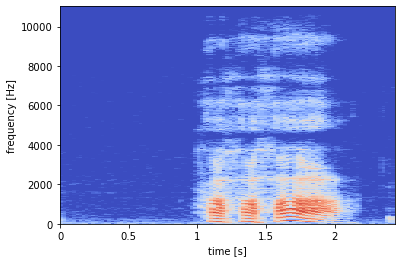

In [3]:
# View the short term fourier transform of a randomly selected audio file from the training data

plt.figsize = (20,5)
from librosa.display import specshow
X = librosa.stft(x)
X_dB = librosa.amplitude_to_db(np.abs(X))
specshow(X_dB, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.xlabel('time [s]')
plt.ylabel('frequency [Hz]')

There are 6 sincere and 6 fake laughters in the training dataset:

> sincere_list: 
['crying_histerical.wav', 'donkey_hehehehe.wav', 'fainty_long.wav', 'fainty_short.wav', 'histerical_ha.wav','histerical_he.wav']

> fake_list:
['skeptical.wav', 'sneaky.wav', 'was_right.wav', 'winning.wav', 'confirmation.wav', 'confirmation2.wav']


duration: 4.265351473922903 seconds


duration: 3.1133333333333333 seconds


duration: 2.729342403628118 seconds


duration: 2.1960090702947848 seconds


duration: 3.412018140589569 seconds


duration: 3.0920181405895693 seconds


duration: 2.068027210884354 seconds


duration: 2.0253514739229024 seconds


duration: 2.430702947845805 seconds


duration: 2.772018140589569 seconds


duration: 2.068027210884354 seconds


duration: 1.8760090702947845 seconds


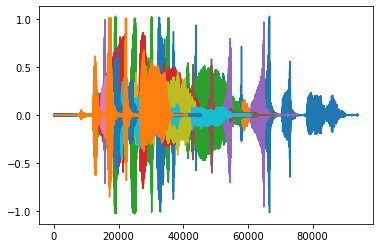

In [4]:
# Import all the training data to view (or hear) some of the audio files

directory = 'laugh'
name_list = ['crying_histerical.wav', 'donkey_hehehehe.wav', 'fainty_long.wav', 'fainty_short.wav', 
             'histerical_ha.wav','histerical_he.wav', 'skeptical.wav', 'sneaky.wav', 'was_right.wav', 
             'confirmation.wav', 'confirmation2.wav','winning.wav']

# display all the audio data
def display_audio_chart(directory, name_list):
    for i in range(len(name_list)):
        directory_path = directory + '/' + name_list[i]
        audio, sampling_rate = librosa.load(directory_path)
        duration = len(audio)/sampling_rate
        print('duration: {} seconds'.format(duration))
        display(Audio(audio, rate=sampling_rate))
        plt.plot(audio)
        
display_audio_chart('laugh', name_list)


Take a closer look to a few of the audio files. They are all in different lengths and amplitudes. We need their short term fourier transform to categorize them.

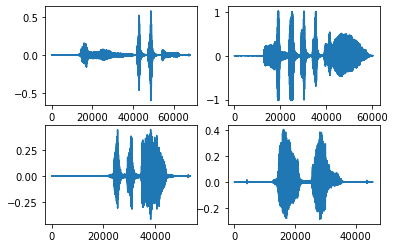

In [5]:
# View some of the audio files

fig = plt.figure()

ax = fig.add_subplot(2, 2, 1)
x, sampling_rate = librosa.load('laugh/histerical_he.wav')
ax.plot(x, clip_on = False)

ax = fig.add_subplot(2, 2, 2)
x, sampling_rate = librosa.load('laugh/fainty_long.wav')
ax.plot(x, clip_on = False)

ax = fig.add_subplot(2, 2, 3)
x, sampling_rate = librosa.load('laugh/was_right.wav')
ax.plot(x, clip_on = False)

ax = fig.add_subplot(2, 2, 4)
x, sampling_rate = librosa.load('laugh/skeptical.wav')
ax.plot(x, clip_on = False)


Since the length of the videos are different, do some padding and extend all audio files to total 5.94 seconds. This awkward audio length is manually picked so that a 128 x 256 resolution mel spectogram would suffice. 


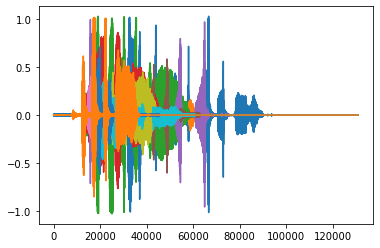

In [6]:
# Do padding until all files have the same length and then store the padded audio files in a dictionary

def do_padding(directory, sampling_rate, name_list, total_length):
    audio_dict = {}
    for i in range(len(name_list)):
        # access the file
        directory_path = directory + '/' + name_list[i]
        # load the file into an audio format 
        audio, sampling_rate = librosa.load(directory_path)
        # check the duration of the audio file
        duration = len(audio)
        # if duration is longer thatn total_length cut it to 5 seconds
        if duration > 131000:
            audio = audio[:131000]
            audio_dict[name_list[i]] = audio
            continue
        extra_pads_needed = np.zeros(131000 - duration) # 131000 sampling points is about 5.94 seconds (sr = 22050)
        audio = np.concatenate((audio, extra_pads_needed), axis = 0)
        # view each file
        # print('audio total: {} sample points'.format(len(audio)))
        # print('length: {}, seconds'.format(len(audio)/sampling_rate))
        # save each file to audio dictionary
        audio_dict[name_list[i]] = audio 
        # play the files
        # display(Audio(audio, rate=sampling_rate))
        # plot all audio files in one chart 
        plt.plot(audio)
    return audio_dict
train_dict = do_padding('laugh', sampling_rate, name_list, 5)

All audio files are now padded to apprx 5.95 seconds and stored in a dictionary


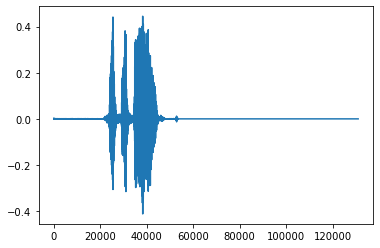

In [7]:
# Check if the audio files are stored properly

plt.plot(train_dict['was_right.wav'])
display(Audio(train_dict['was_right.wav'], rate=sampling_rate))
# print(train_dict['was_right.wav'].shape)

(131000,)


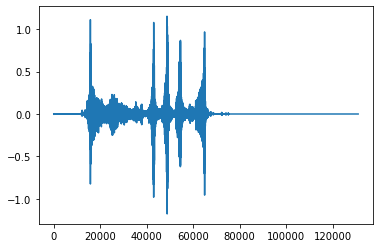

In [8]:
# Just for fun: Mix up some data and let's play with it. 

b = train_dict['donkey_hehehehe.wav']
c = train_dict['histerical_he.wav']
d = train_dict['histerical_ha.wav']
e = train_dict['fainty_long.wav']

f = b*0.5 + 2*c + d + 0.1*e
plt.plot(f)
display(Audio(f, rate=sampling_rate))
print(f.shape)

Humans perceive loudness on a logarithmic scale that is why we will transform the amplitudes of these audio files into the decibel scale

(128, 256) <class 'numpy.ndarray'>


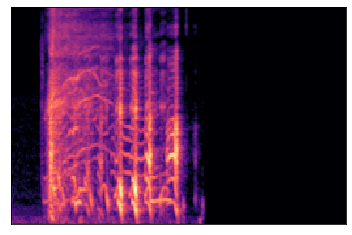

In [9]:
# Turn this audio file into a mel-spectogram

S = librosa.feature.melspectrogram(y=f, sr=sampling_rate, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB) 
print(S_dB.shape, type(S_dB))

Turn all the audio files into Mel Spectrograms and then into images. 

In [10]:
# Do the transformation for all audio files and store the images of the mel specs into a new dictionary

image_of_mel_specs = {}
for k in train_dict.keys():
    S = librosa.feature.melspectrogram(y=train_dict[k], sr=sampling_rate, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    image_of_mel_specs[k] = S_dB

View the dictionary and some items in it:

* librosa.display.specshow(image_of_mel_specs['fainty_long.wav'])
* librosa.display.specshow(image_of_mel_specs['donkey_hehehehe.wav'])

For simplicity, working on gray scale would be more efficient instead of multiple colors. Turn the mel specs into a gray 2d image by scaling it (0 is white, 255 is black)


In [11]:
# Turn the mel specs into a gray 2d image

def spec_to_gray_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled


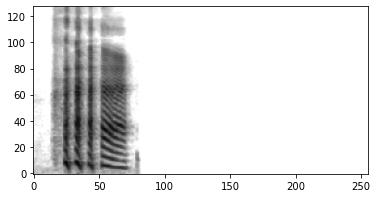

In [12]:
# View the mixed laughter images

test = spec_to_gray_image(S_dB)
plt.imshow(test, cmap = plt.cm.binary, origin = 0)

In [13]:
# Convert all laughter audio files into gray mel specs.

gray_scaled_mels = {}
for k in image_of_mel_specs.keys():
    gray_scaled_mel_image = spec_to_gray_image(image_of_mel_specs[k], eps=1e-6)
    gray_scaled_mels[k] = gray_scaled_mel_image


12
(128, 256)
[ 80  62  36  29  42  59  53  47  61  54  43  52  44  45  41  54  56  35
  38  43  60  68  63  55  55  46  51  48  55  63  47  54  56  47  61  62
  49  58  75  83 105 117 109  82  69  76  76  79  88  99  88  73  79  82
  84  98  92  81  74  66  70  77  62  65  65  81  75  70  77  71  69  59
  63  69  59  57  59  67  70  56  54  57  44  56  57  62  68  48  16   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 

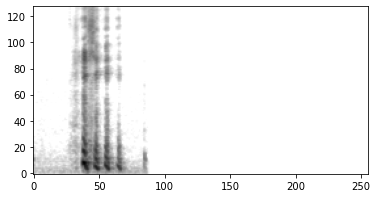

In [14]:
# View some of the items

plt.imshow(gray_scaled_mels['sneaky.wav'], cmap = plt.cm.binary, origin = 0)
print(len(gray_scaled_mels))
print(gray_scaled_mels['sneaky.wav'].shape)
print(gray_scaled_mels['sneaky.wav'][0]) # first line's values 

In [15]:
# Normalize the values of the training set

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

normalized_gray_scaled_mels = {}
for k, v in gray_scaled_mels.items():
    # normalize the values between 0 and 1
    normalized_item = min_max_scaler.fit_transform(gray_scaled_mels[k])
    # convert the data into 1 x 128 x 256 to train it with pytorch
    normalized_item = normalized_item[np.newaxis, :]
    # store the normalized and reshaped items into dictionary
    normalized_gray_scaled_mels[k] = normalized_item

# check if the shape and the values in the nd arrays stored for training looks right
print(normalized_gray_scaled_mels['histerical_he.wav'].shape)
normalized_gray_scaled_mels['histerical_he.wav'][0][0][100:150] # a small piece of the normalized gray scale mels. 

(1, 128, 256)


array([0.48734177, 0.48550725, 0.40650407, 0.38095238, 0.52688172,
       0.43262411, 0.40932642, 0.37198068, 0.33009709, 0.33830846,
       0.31282051, 0.29100529, 0.29533679, 0.30456853, 0.36683417,
       0.43654822, 0.41326531, 0.35714286, 0.32989691, 0.29591837,
       0.33668342, 0.34848485, 0.36315789, 0.28823529, 0.34558824,
       0.49180328, 0.50515464, 0.59139785, 0.79347826, 0.68965517,
       0.63218391, 0.47692308, 0.47945205, 0.59541985, 0.73529412,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

1 double_high_pitch.wav (1, 1, 128, 256)
1 surprise.wav (1, 1, 128, 256)
1 fake4.wav (1, 1, 128, 256)
1 fake5.wav (1, 1, 128, 256)


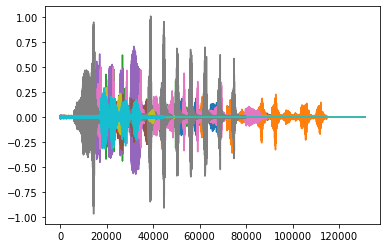

In [16]:
# Prepare the validation and test sets for neural networks using only one function to automate everything done above

# Note: 'laugh_test' folder has total 10 audio files holding test and validation audio files
# create a training validation set with 3 sincere 3 fake files 
# create a test set with 2 sincere and 2 fake files

validation_and_test_data = ['last_breath.wav', 'short_breath.wav', 'snake.wav', 'double_high_pitch.wav', 
                            'surprise.wav', 'fake1.wav', 'fake2.wav', 'fake3.wav', 'fake4.wav', 'fake5.wav']

sincere_list = ['last_breath.wav', 'short_breath.wav', 'snake.wav', 'double_high_pitch.wav', 'surprise.wav']

fake_list = ['fake1.wav', 'fake2.wav', 'fake3.wav', 'fake4.wav', 'fake5.wav']

validation_list = ['last_breath.wav', 'short_breath.wav', 'snake.wav', 'fake1.wav', 'fake2.wav', 'fake3.wav']

test_list = ['double_high_pitch.wav', 'surprise.wav','fake4.wav', 'fake5.wav']


# upload the files, do the padding, store the audio files in a dictionary
validation_audio = do_padding('laugh_test', sampling_rate, validation_list, 5)
test_audio = do_padding('laugh_test', sampling_rate, test_list, 5)
# print(len(validation_audio), len(test_audio)) 


# extract the mel spec, normalize, and test the audio files with the trained network 
def prepare_data(dictionary_to_unpack, sampling_rate = 22050):
    dataset = {}
    # for each item in the dictionary
    for k,v in dictionary_to_unpack.items():
        # take the mel_specs
        mel_spectogram = librosa.feature.melspectrogram(y=dictionary_to_unpack[k], sr=sampling_rate, 
                                                        n_mels=128, fmax=8000)
        # convert into decibel scales
        S_dB = librosa.power_to_db(mel_spectogram, ref=np.max)
        # convert into gray image
        gray_scaled_mel_image = spec_to_gray_image(S_dB, eps=1e-6)
        # normalize the values between 0-1
        normalized_item = min_max_scaler.fit_transform(gray_scaled_mel_image)
        # reshape the normalized data into 128 x 256 shape into one dimension
        flattened_item = normalized_item.reshape(1,1,128,256)
        # store it to dataset dictionary
        dataset[k] = flattened_item
    return dataset


# training_set
training_set = prepare_data(train_dict)

# validation set
validation_set = prepare_data(validation_audio)

# test set
test_set = prepare_data(test_audio)


# double check the data:
# for k, v in validation_set.items():
#     print(len(validation_set[k]), k, validation_set[k].shape)
# for k, v in training_set.items():    
#     print(len(training_set[k]), k,  training_set[k].shape)
for k, v in test_set.items():    
    print(len(test_set[k]), k, test_set[k].shape)


In [17]:
# Train a convolutional neural network with the training data and observe its performance with the validation set

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = 'cpu'


# all audio files in the training set:
name_list = ['crying_histerical.wav', 'donkey_hehehehe.wav', 'fainty_long.wav', 'fainty_short.wav', 
             'histerical_ha.wav','histerical_he.wav', 'skeptical.wav', 'sneaky.wav', 'was_right.wav', 
             'confirmation.wav', 'confirmation2.wav','winning.wav']

# the name of the files that has sincere laughters:
sincere_list = ['crying_histerical.wav', 'donkey_hehehehe.wav', 'fainty_long.wav', 'fainty_short.wav', 
             'histerical_ha.wav','histerical_he.wav']

# the name of the files that has fake laughters:
fake_list = ['skeptical.wav', 'sneaky.wav', 'was_right.wav', 'winning.wav', 
             'confirmation.wav', 'confirmation2.wav']

# the name of the files in validation list:
validation_list = ['last_breath.wav', 'short_breath.wav', 'snake.wav', 'fake1.wav', 'fake2.wav', 'fake3.wav']

# the name of the files in test list:
test_list = ['double_high_pitch.wav', 'surprise.wav','fake4.wav', 'fake5.wav']


# convert numpy to tensor and then reshape it for training.
def convert_np_into_tensor(dictionary):
    output_dict = {}
    for k, v in dictionary.items():
        normalized_image = dictionary[k]
        normalized_image = torch.tensor(normalized_image, dtype = float)
        # each image is (1, 128, 256)
        output_dict[k] = normalized_image
    return output_dict

training_tensor_dict = convert_np_into_tensor(training_set)
validation_tensor_dict = convert_np_into_tensor(validation_set)
test_tensor_dict = convert_np_into_tensor(test_set)

# check the data
for k, v in training_tensor_dict.items():    
    print(len(training_tensor_dict[k]), k, type(training_tensor_dict[k]), training_tensor_dict[k].shape)

list(training_tensor_dict)

1 crying_histerical.wav <class 'torch.Tensor'> torch.Size([1, 1, 128, 256])
1 donkey_hehehehe.wav <class 'torch.Tensor'> torch.Size([1, 1, 128, 256])
1 fainty_long.wav <class 'torch.Tensor'> torch.Size([1, 1, 128, 256])
1 fainty_short.wav <class 'torch.Tensor'> torch.Size([1, 1, 128, 256])
1 histerical_ha.wav <class 'torch.Tensor'> torch.Size([1, 1, 128, 256])
1 histerical_he.wav <class 'torch.Tensor'> torch.Size([1, 1, 128, 256])
1 skeptical.wav <class 'torch.Tensor'> torch.Size([1, 1, 128, 256])
1 sneaky.wav <class 'torch.Tensor'> torch.Size([1, 1, 128, 256])
1 was_right.wav <class 'torch.Tensor'> torch.Size([1, 1, 128, 256])
1 confirmation.wav <class 'torch.Tensor'> torch.Size([1, 1, 128, 256])
1 confirmation2.wav <class 'torch.Tensor'> torch.Size([1, 1, 128, 256])
1 winning.wav <class 'torch.Tensor'> torch.Size([1, 1, 128, 256])


['crying_histerical.wav',
 'donkey_hehehehe.wav',
 'fainty_long.wav',
 'fainty_short.wav',
 'histerical_ha.wav',
 'histerical_he.wav',
 'skeptical.wav',
 'sneaky.wav',
 'was_right.wav',
 'confirmation.wav',
 'confirmation2.wav',
 'winning.wav']

In [18]:
# Note: The below model was intentionally overfit
# use GPU if needed by sending the data and target to device and change device name to 'gpu'
# data, target = data.to(device), target.to(device) 


# build the model
class Net(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.conv1 = torch.nn.Conv2d(1, 2, kernel_size = 5) # in , out, kernel size
        self.conv2 = torch.nn.Conv2d(2, 4, kernel_size = 5) # in , out, kerner size
        self.conv3 = torch.nn.Conv2d(4, 8, kernel_size = 4) # in , out, kerner size
        self.fcl1 = torch.nn.Linear(8*13*29, 2) # in, out
        
        
    def forward(self, x):
        x = self.conv1(x)  # input 1 x 128 x 256 ---> (1,2) 5x5 conv1 ----> output 2 x 124 x 252 
        x = torch.nn.functional.dropout(x) # 2 x 124 x 252 
        x = torch.nn.functional.max_pool2d(x, 2) # maxpool1(2,2) ----> 2 x 62 x 126 
        x = torch.relu(x) # 2 x 62 x 126 
        x = self.conv2(x) # input 2 x 62 x 126 ----> (2,4) 5x5 conv2 ----> output 4 x 58 x 122
        x = torch.nn.functional.dropout(x) # 4 x 58 x 122 
        x = torch.nn.functional.max_pool2d(x, 2) # maxpool2(2,2) ----> 4 x 29 x 61
        x = torch.relu(x) # 4 x 29 x 61
        x = self.conv3(x)  # input 4 x 29 x 61 ---> (4,8) 4x4 conv1 ----> output 8 x 26 x 58 
        x = torch.nn.functional.dropout(x) # 8 x 26 x 58 
        x = torch.nn.functional.max_pool2d(x, 2) # maxpool1(2,2) ----> 8 x 13 x 29 
        x = torch.relu(x) # 8 x 13 x 29 
        x = x.view(-1, 8*13*29) # input 8 x 13 x 29 ----> output (1 x 8 x 13 x 29 ) flatten to one dimension
        x = self.fcl1(x) # input: (8*13*29), output: 2, a scalar number
        # x = torch.sigmoid(x) # output the logit with the sigmoid function could have been used if output dim: 1
        return x

    
# instantiate the object
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

# train all the instances for each epoch
epochs = 10
for epoch in range(epochs):
    model.train()
    for i in range(100):
        # zero grad the optimizer
        optimizer.zero_grad()
        # to avoid RuntimeError: Expected object of scalar type Double but got scalar type Float, change the type
        model = model.double()
        # pick a random item in the dictionary
        random_key = np.random.choice(list(training_tensor_dict))
        # forward prop
        output = model(training_tensor_dict[random_key])
        # check the loss
        if random_key in fake_list:
            y = torch.tensor(0, dtype = torch.long).unsqueeze(0)
        elif random_key in sincere_list: # if k is in sincere list, y_pred is equal to 1
            y = torch.tensor(1, dtype = torch.long).unsqueeze(0)
        else:
            print('item not found')
            break
        loss = criterion(output, y)# cross entropy loss
        
        # ouput the loss and validate the loss with the validation set
        if i == 99:
            print('training loss', loss.item(), 'at epoch:', epoch)
            # validation loss
            random_key = np.random.choice(list(validation_tensor_dict))
            if random_key.startswith('f'):
                y = torch.tensor(0, dtype = torch.long).unsqueeze(0)
            else:
                y = torch.tensor(1, dtype = torch.long).unsqueeze(0)
            result = model(validation_tensor_dict[random_key])
            validation_data_loss = criterion(result , y)
            print('validation loss:', validation_data_loss.item())
        # backprop
        loss.backward()
        # update the parameters
        optimizer.step()
        
print('Finished Training')

# test the model
model.eval()
for i in test_list:
    random_key = np.random.choice(list(test_tensor_dict))
    if random_key.startswith('f'):
        y = torch.tensor(0, dtype = torch.long).unsqueeze(0)
    else:
        y = torch.tensor(1, dtype = torch.long).unsqueeze(0)
    test_output = model(test_tensor_dict[random_key])
    output = np.argmax(test_output.detach().numpy())
    if output == 0:
        status = 'Fake'
    else:
        output == 1
        status = 'Sincere'
    print('assign 0 for fake, 1 for sincere:', output , random_key)

for i in validation_list:
    random_key = np.random.choice(list(validation_tensor_dict))
    if random_key.startswith('f'):
        y = torch.tensor(0, dtype = torch.long).unsqueeze(0)
    else:
        y = torch.tensor(1, dtype = torch.long).unsqueeze(0)
    test_output = model(validation_tensor_dict[random_key])
    output = np.argmax(test_output.detach().numpy())
    if output == 0:
        status = 'Fake'
    else:
        output == 1
        status = 'Sincere'
    print('assign 0 for fake, 1 for sincere:', output , random_key)

 

training loss 1.2164932792264147 at epoch: 0
validation loss: 0.0026397057362467064
training loss 0.0008028700138106476 at epoch: 1
validation loss: 0.000490076608102618
training loss 0.006298924993212613 at epoch: 2
validation loss: 8.963225767982692e-05
training loss 0.00045933506575942195 at epoch: 3
validation loss: 6.7122995104389115e-06
training loss 4.888114344320193e-07 at epoch: 4
validation loss: 0.00016534232936334965
training loss 1.8777723878057926e-07 at epoch: 5
validation loss: 1.0998410402189023e-05
training loss 3.0464519795709656e-13 at epoch: 6
validation loss: 2.9737909746563356e-06
training loss 0.00014132252107306457 at epoch: 7
validation loss: 7.738064353002434e-07
training loss 1.640277801038504e-05 at epoch: 8
validation loss: 4.721737286159154e-06
training loss 6.207368617670596e-07 at epoch: 9
validation loss: 2.089065073656262e-07
Finished Training
assign 0 for fake, 1 for sincere: 0 fake5.wav
assign 0 for fake, 1 for sincere: 0 fake4.wav
assign 0 for fake

Reminder: The name of the files in test and validation lists are:
* test_list = ['double_high_pitch.wav', 'surprise.wav','fake4.wav', 'fake5.wav']
* validation_list = ['last_breath.wav', 'short_breath.wav', 'snake.wav', 'fake1.wav', 'fake2.wav', 'fake3.wav']

## Conclusion

[[ go back to the top ]](#Table-of-contents)

100 percent accuracy achieved on detecting the sincerity of the laughters of the smallest, and the most awkward audio dataset. 